## Seq_Data Clustering in PNAS 2015 - Early signaling dynamics of the EGFR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
from msresist.clustering import MassSpecClustering
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.FileExporter import create_download_link


import warnings
warnings.simplefilter("ignore")

### Make MS Data Compatible

In [2]:
# pd.set_option('display.max_rows', 2000)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_colwidth', 1000)

fulldata = pd.read_csv("msresist/data/MS/Raw/pnas.forestEGF.sd01.csv", header=0).iloc[:, :14].sort_values(by="Protein")
print("number of different peptides captured in this data set: ", fulldata.drop_duplicates(["Protein", "Sequence"]).shape[0])

#Format Name
names = []
list(map(lambda v: names.append(v.split("OS")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names
names = []
list(map(lambda v: names.append(v.split(" [H")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names
names = []
list(map(lambda v: names.append(v.split(" isoform")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names


#Format Seqs and map to proteome to obtain motifs
fulldata["Sequence"] = [seq.replace("(pY)", "y") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(pS)", "s") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(pT)", "t") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(M)", "M") for seq in list(fulldata.iloc[:, 1])]
fulldata = pYmotifs(fulldata, names)
fulldata = preprocess_seqs(fulldata, "Y")

number of different peptides captured in this data set:  463


Split data by treatment conditions:

In [3]:
E100 = fulldata[fulldata["Condition"].str.contains("EGF 100 nM")]
E20 = fulldata[fulldata["Condition"].str.contains("EGF 20 nM") & ~fulldata["Condition"].str.contains("Na3VO4") & ~fulldata["Condition"].str.contains("dasatinib")]
E20_Na3VO4 = fulldata[fulldata["Condition"].str.contains("Na3VO4")]
E20_dasatinib = fulldata[fulldata["Condition"].str.contains("dasatinib")]
E10 = fulldata[fulldata["Condition"].str.contains("EGF 10 nM")]
E5 = fulldata[fulldata["Condition"].str.contains("EGF 5 nM")]
E2_5 = fulldata[fulldata["Condition"].str.contains("EGF 2.5 nM")]
E1 = fulldata[fulldata["Condition"].str.contains("EGF 1 nM")]
E0_4 = fulldata[fulldata["Condition"].str.contains("EGF 0.4 nM")]

Checked if it's worth concatenating, take integral, and frame data set with conditions as features. However, it seems that the number of overlapping peptides is fairly small.

In [4]:
E1020100 = pd.concat([E10, E20, E100])

dups = pd.DataFrame(pd.pivot_table(E1020100, index=["Protein", "Sequence"], aggfunc="size")).reset_index()
dups.columns = ["Protein", "Sequence", "Reps"]
print("overlapping peptides across conditions Erl 10nM, 20nM, 100nM :", dups[dups["Reps"] ==  3].shape[0])

overlapping peptides across conditions Erl 10nM, 20nM, 100nM : 63


### Run Clustering

In [5]:
ncl = 7
GMMweight = 0

#Not being used here, needed for any sklearn-compatible estimator
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw3.csv').iloc[:30, :11]


def plotclustermeans(centers, ncl):
    colors_ = cm.rainbow(np.linspace(0, 1, ncl))

    centers = centers.T

    for i in range(centers.shape[0]):
        ax.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    ax.legend()

    ax.set_xticks(np.arange(centers.shape[1]))
    ax.set_xticklabels(E1020100.columns[5:], rotation=70, rotation_mode="anchor")
    ax.set_ylabel("normalized signal")

As in the SOM clustering they generated, we concatenate E10, E20, and E100 data sets and run the model

In [6]:
data = E1020100.iloc[:, 5:].T 
info = E1020100.iloc[:, :5]

Frist by looking at the sequences only:

#### PAM250

In [7]:
MSC_PAM = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)

In [8]:
E1020100_PAM = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_PAM.labels_)])
E1020100_PAM[E1020100_PAM["Protein"].str.contains("Epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster
448,Epidermal growth factor receptor,AENAEyLRVAP,EGF 10 nM,Y1197-p,3,0.022265,0.25684,0.29291,0.60875,0.64395,0.70952,0.81356,0.78021,1.07160,5
449,Epidermal growth factor receptor,AENAEyLRVAP,EGF 100 nM,Y1197-p,3,0.028468,0.47494,0.88448,0.88706,0.76070,0.71637,0.75840,0.77722,0.96055,5
451,Epidermal growth factor receptor,AENAEyLRVAP,EGF 20 nM,Y1197-p,3,0.016375,0.44252,0.60532,0.61964,0.69079,0.80663,0.82686,0.88925,0.92430,5
528,Epidermal growth factor receptor substrate 15,ANFSAyPSEED,EGF 10 nM,Y849-p,3,0.048901,0.11200,0.20959,0.24469,0.42103,0.68637,0.81495,1.32240,1.19770,7
441,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 20 nM,Y1172-p,3,0.049061,0.42999,0.31044,0.57841,0.70229,0.85916,0.76802,0.89607,0.90925,5
438,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 10 nM,Y1172-p,3,0.062655,0.28720,0.37602,0.66722,0.71949,0.70297,0.77919,0.75463,1.04510,5
439,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 100 nM,Y1172-p,3,0.037179,0.49476,0.92378,0.92226,0.77096,0.76776,0.75425,0.72710,0.90885,5
464,Epidermal growth factor receptor,LPVPEyINQSV,EGF 20 nM,Y1092-p,2,0.122350,0.55876,0.64893,0.64876,0.77934,0.77807,0.84563,0.86994,0.82918,7
462,Epidermal growth factor receptor,LPVPEyINQSV,EGF 100 nM,Y1092-p,3,0.069425,0.65206,0.84368,0.78086,0.67607,0.68726,0.67866,0.78641,0.91290,7
461,Epidermal growth factor receptor,LPVPEyINQSV,EGF 10 nM,Y1092-p,3,0.074811,0.34431,0.44630,0.66382,0.72987,0.67122,0.76250,0.69868,1.01070,7


In [9]:
MSC_PAM.clustermembers(E1020100.T)

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,...,Pos_C6,r2/Std_C6,BioReps_C6,Prot_C7,abbv_C7,seqs_C7,UniprotAcc_C7,Pos_C7,r2/Std_C7,BioReps_C7
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",Y775-p,DYGALyEGRNP,EGF 10 nM,3,0.54347,0.343060,Caskin-2,Y253-p,NIRNTyNQTAL,...,2.0,0.37285,0.120760,Guanine nucleotide exchange factor VAV2,Y871-p,WFPSTyVEEEG,EGF 10 nM,3.0,0.56824,0.41949
1,Dedicator of cytokinesis protein 9,Y1237-p,GIASPyTTSTP,EGF 10 nM,2,0.78216,0.247500,GRB2-associated-binding protein 1,Y627-p,DKQVEyLDLDL,...,3.0,0.56684,0.251920,OTU domain-containing protein 7B,Y779-p,SYSNGyREPPE,EGF 10 nM,3.0,0.21006,0.14954
2,E3 ubiquitin-protein ligase CBL,Y455-p,APSPNyDDDDD,EGF 10 nM,2,0.44523,0.065701,GRB2-associated-binding protein 1,Y627-p,DKQVEyLDLDL,...,3.0,0.23623,0.111990,Afadin,Y1230-p,TYTREyFTFPA,EGF 10 nM,3.0,0.51501,0.36851
3,E3 ubiquitin-protein ligase CBL,Y552-p,PPDRPySVGAE,EGF 10 nM,2,0.42706,0.269600,PDZ domain-containing protein 11,Y7-p,DSRIPyDDYPV,...,3.0,0.20294,0.057958,Catenin delta-1,Y221-p,HYEDGyPGGSD,EGF 10 nM,2.0,0.49577,0.26845
4,GRB2-associated-binding protein 1,Y406-p,SSQDCyDIPRA,EGF 10 nM,3,0.26646,0.053138,Protein scribble homolog,Y1360-p,RERQKyFELEV,...,2.0,0.34740,0.325180,Catenin delta-1,Y217-p,GYSRHyEDGYP,EGF 10 nM,3.0,0.52515,0.28123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Receptor-type tyrosine-protein phosphatase kappa,Y858-p,GTESPyQTGQL,EGF 100 nM,3,0.70160,0.405430,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,Src substrate cortactin,Y334-p,QVSSAyQKTVP,EGF 100 nM,3,0.65213,0.204810,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,Src substrate cortactin,Y421-p,PSSPVyEDAAS,EGF 100 nM,2,0.27425,0.102090,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,Tyrosine-protein kinase Fer,Y402-p,PPVVNyEEDAR,EGF 100 nM,3,0.72725,0.558460,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


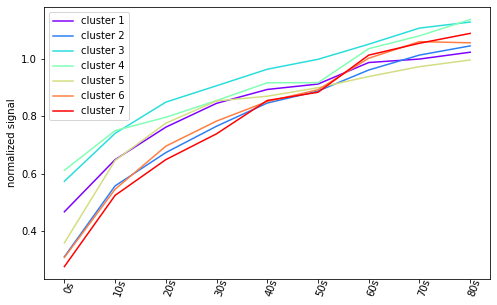

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
centers_PAM = MSC_PAM.transform(data)
plotclustermeans(centers_PAM, ncl)

Including data:

In [11]:
GMMweight = 2.5

MSC_PAM25 = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)
centers_PAM25 = MSC_PAM25.transform(data)

E1020100_PAM25 = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_PAM25.labels_)])
E1020100_PAM25[E1020100_PAM25["Protein"].str.contains("epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster


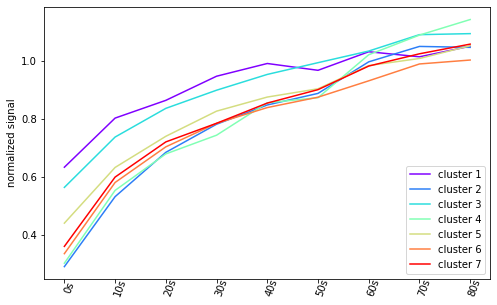

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_PAM25, ncl)

In [13]:
MSC_PAM25.clustermembers(E1020100_PAM25.T)

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,...,Pos_C6,r2/Std_C6,BioReps_C6,Prot_C7,abbv_C7,seqs_C7,UniprotAcc_C7,Pos_C7,r2/Std_C7,BioReps_C7
0,GRB2-associated-binding protein 1,Y406-p,SSQDCyDIPRA,EGF 10 nM,3.0,0.26646,0.053138,E3 ubiquitin-protein ligase CBL-B,Y802-p,RTPSDyDLLIP,...,2.0,0.79130,0.578110,"1-phosphatidylinositol 4,5-bisphosphate phosph...",Y783-p,RNPGFyVEANP,EGF 10 nM,2.0,0.37285,0.120760
1,GRB2-associated-binding protein 1,Y406-p,SSQDCyDIPRA,EGF 10 nM,2.0,0.26484,0.063617,GRB2-associated-binding protein 1,Y659-p,DERVDyVVVDQ,...,3.0,0.25260,0.058605,E3 ubiquitin-protein ligase CBL,Y455-p,APSPNyDDDDD,EGF 10 nM,2.0,0.44523,0.065701
2,GRB2-associated-binding protein 1,Y259-p,VDSSLyNLPRS,EGF 10 nM,3.0,0.47190,0.336200,GRB2-associated-binding protein 1,Y659-p,DERVDyVVVDQ,...,3.0,0.22201,0.022278,Caveolin-1,Y6-p,MSGGKyVDSEG,EGF 10 nM,2.0,0.60030,0.645000
3,SH2 domain-containing adapter protein B,Y336-p,RPADEyDQPWE,EGF 10 nM,2.0,0.51276,0.147420,PDZ and LIM domain protein 1,Y321-p,TPPEGyEVVTV,...,2.0,0.58718,0.543610,Desmoglein-2,Y979-p,LVDQPyANEGT,EGF 10 nM,3.0,0.43812,0.223780
4,Breast cancer anti-estrogen resistance protein 1,Y234-p,PEQDEyDIPRH,EGF 10 nM,3.0,1.09860,1.013500,PDZ and LIM domain protein 4,Y316-p,KPPEGyDVVAV,...,3.0,0.47926,0.204630,"1-phosphatidylinositol 4,5-bisphosphate phosph...",Y783-p,RNPGFyVEANP,EGF 10 nM,3.0,0.40225,0.136500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tensin-3,Y802-p,KAGVDyAPNLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tensin-4,Y150-p,ALDIKyIEVTS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tensin-4,Y150-p,ALDIKyIEVTS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BINOMIAL:

In [20]:
GMMweight = 0

MSC_BPM = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers_BPM = MSC_BPM.transform(data)

In [24]:
E1020100_BPM = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_BPM.labels_)])
E1020100_BPM[E1020100_BPM["Protein"].str.contains("Epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster
448,Epidermal growth factor receptor,AENAEyLRVAP,EGF 10 nM,Y1197-p,3,0.022265,0.25684,0.29291,0.60875,0.64395,0.70952,0.81356,0.78021,1.07160,5
449,Epidermal growth factor receptor,AENAEyLRVAP,EGF 100 nM,Y1197-p,3,0.028468,0.47494,0.88448,0.88706,0.76070,0.71637,0.75840,0.77722,0.96055,5
451,Epidermal growth factor receptor,AENAEyLRVAP,EGF 20 nM,Y1197-p,3,0.016375,0.44252,0.60532,0.61964,0.69079,0.80663,0.82686,0.88925,0.92430,5
528,Epidermal growth factor receptor substrate 15,ANFSAyPSEED,EGF 10 nM,Y849-p,3,0.048901,0.11200,0.20959,0.24469,0.42103,0.68637,0.81495,1.32240,1.19770,1
441,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 20 nM,Y1172-p,3,0.049061,0.42999,0.31044,0.57841,0.70229,0.85916,0.76802,0.89607,0.90925,3
438,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 10 nM,Y1172-p,3,0.062655,0.28720,0.37602,0.66722,0.71949,0.70297,0.77919,0.75463,1.04510,3
439,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 100 nM,Y1172-p,3,0.037179,0.49476,0.92378,0.92226,0.77096,0.76776,0.75425,0.72710,0.90885,3
464,Epidermal growth factor receptor,LPVPEyINQSV,EGF 20 nM,Y1092-p,2,0.122350,0.55876,0.64893,0.64876,0.77934,0.77807,0.84563,0.86994,0.82918,5
462,Epidermal growth factor receptor,LPVPEyINQSV,EGF 100 nM,Y1092-p,3,0.069425,0.65206,0.84368,0.78086,0.67607,0.68726,0.67866,0.78641,0.91290,5
461,Epidermal growth factor receptor,LPVPEyINQSV,EGF 10 nM,Y1092-p,3,0.074811,0.34431,0.44630,0.66382,0.72987,0.67122,0.76250,0.69868,1.01070,5


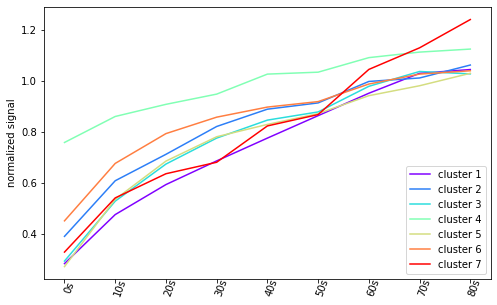

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_BPM, ncl)

In [ ]:
GMMweight = 2.5

MSC_BPM25 = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers_BPM25 = MSC_BPM25.transform(data)

E1020100_BPM25 = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_BPM25.labels_)])
E1020100_BPM25[E1020100_BPM25["Protein"].str.contains("epidermal growth factor receptor")].sort_values(by="Sequence")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_BPM25, ncl)

In [ ]:
xls = MSC.clustermembers(E1020100.T)
create_download_link(xls, "PNAS_5Clusters_weight=2.5.csv")